# Wikipedia Crawling Experiment

### Idea.
In on the Udacity's lab the instructor shared an idea that if you start at random article and keep clicking on the first link you see (excluding citations), then you will eventually get to Philosophy page. I have enhanced the algorithm to take the first link excluding references to the word origin. Otherwise, we always get to language page (typically - Latin).  
The question I tried to explore is what are the most frequent pages we end our search at - will it be Philosophy or something else? 

### Tools
For the purpose of this lab I am going to use the following libraries: 
- requests;  
- BeutifulSoup;  
- urllib
- time

In [1]:
import requests
import time
import urllib
import bs4

### Search conditions
<p>First, we need to describe the problem setup.</p>

#### First link
<p><b>The first link</b> is the first link we see in the first actual paragraph of the Wikipedia article, EXCLUDING links to references and links about the language.</p>

<p>Sample fragment from Wikipedia:</p>
<hr>
<p>The <b>Goidelic</b> <span class="nowrap"><span class="IPA nopopups noexcerpt"><a href="/wiki/Help:IPA/English" title="Help:IPA/English">/<span style="border-bottom:1px dotted"><span title="/ɡ/: &#39;g&#39; in &#39;guy&#39;">ɡ</span><span title="/ɔɪ/: &#39;oi&#39; in &#39;choice&#39;">ɔɪ</span><span title="/ˈ/: primary stress follows">ˈ</span><span title="&#39;d&#39; in &#39;dye&#39;">d</span><span title="/ɛ/: &#39;e&#39; in &#39;dress&#39;">ɛ</span><span title="&#39;l&#39; in &#39;lie&#39;">l</span><span title="/ɪ/: &#39;i&#39; in &#39;kit&#39;">ɪ</span><span title="&#39;k&#39; in &#39;kind&#39;">k</span></span>/</a></span></span> or <b>Gaelic languages</b> (<a href="/wiki/Irish_language" title="Irish language">Irish</a>: <i lang="ga">teangacha Gaelacha</i>; <a href="/wiki/Scottish_Gaelic_language" class="mw-redirect" title="Scottish Gaelic language">Scottish Gaelic</a>: <i lang="gd">cànanan Goidhealach</i>; <a href="/wiki/Manx_language" title="Manx language">Manx</a>: <i lang="gv">çhengaghyn Gaelgagh</i>) form one of the two groups of <a href="/wiki/Insular_Celtic_languages" title="Insular Celtic languages">Insular Celtic languages</a>, the other being the <a href="/wiki/Brittonic_languages" title="Brittonic languages">Brittonic languages</a>.<sup id="cite_ref-2" class="reference"><a href="#cite_note-2">&#91;2&#93;</a></sup>
</p>
<hr>

<p>In this case we should ignore the link to Irish language and "click" on "Insular Celtic languages"</p>

#### Search stop conditions
We should stop in the following cases: 
- if the chain exceeds the given length
- if we get into a loop (e.g. Reality -> Existsence -> Reality)
- if we get to an article with no links at all (in the main content)
- if we reach an article on Philosophy

### Implementation

In [2]:
# start url - if we click on that link we'll get to a random Wikipedia article
start_url = "https://en.wikipedia.org/wiki/Special:Random"
target_url = "https://en.wikipedia.org/wiki/Philosophy"

My main modification was for the function of extracting the first link. The algorithm is as follows:  
1) get all the html code inside the parentheses (since all language remarks are inside the parentheses);  
2) extract all the links from the code inside of the parentheses;  
3) when extracting the first link - loop until we meet a link that is NOT among the links obtained in step 2.

The first version simply took everything after the parentheses, but this approach failed on several examples with parentheses. 

In [3]:
def get_links_in_parentheses(html_element):
    """
    Find all the links that are in the first parentheses in the given html element. 
    Return links in short form (as theyare in Wikipedia). 
    """
    elstr = html_element.prettify()
    parenth_start = elstr.find("(")
    parenth_end = elstr.find(")")
    cleaned_html = elstr[parenth_start:parenth_end+1]
    element = bs4.BeautifulSoup(cleaned_html, "html.parser")
    links = []
    for alink in element.find_all("a", recursive=False):
        link = alink.get('href')
        links.append(link)
    return links

In [4]:
def find_first_link(url):
    """Get the first link on the Wikipedia page that is not a reference
    Core function: taken from Udacity tutorial. I've modified it to 
    search for the correct first link. 
    """
    response = requests.get(url)
    html = response.text
    soup = bs4.BeautifulSoup(html, "html.parser")

    # This div contains the article's body
    content_div = soup.find(id="mw-content-text").find(class_="mw-parser-output")
    
    # stores the first link found in the article, if the article contains no
    # links this value will remain None
    first_link = None
    word = None

    # Find all the direct children of content_div that are paragraphs
    if content_div:
        paragraphs = content_div.find_all("p", recursive=False)
    else:
        return None, None
    for element in paragraphs:
        # Find the first anchor tag that's a direct child of a paragraph.
        # It's important to only look at direct children, because other types
        # of link, e.g. footnotes and pronunciation, could come before the
        # first link to an article. Those other link types aren't direct
        # children though, they're in divs of various classes.
        invalid_links = get_links_in_parentheses(element)
        # find all candidates links
        candidates = element.find_all("a", recursive=False)
        for candidate in candidates:
            # check if the candidate is valid (i.e. it's not a language reference)
            if not candidate.get('href') in invalid_links:
                article_link = candidate.get('href')
                first_link = urllib.parse.urljoin('https://en.wikipedia.org/', article_link)
                word = article_link.split('/')[-1]
                break
        if first_link:
            break

    return first_link, word

Try this function with our example with Goidelic languages: 

In [5]:
find_first_link("https://en.wikipedia.org/wiki/Goidelic_languages")

('https://en.wikipedia.org/wiki/Insular_Celtic_languages',
 'Insular_Celtic_languages')

In [6]:
def continue_crawl(search_history, target_url, max_steps):
    """Checks the conditions for terminating the search. Returns True if:
    - we haven't reached Philosophy article yet
    - the max_steps lengths was not exceeded
    - we're not in a loop (we see the last article in the search history
    for the first time)
    """
    target = search_history[-1] == target_url
    endless = len(search_history) > max_steps
    loop = search_history[-1] in search_history[:-1]
    return not target and not endless and not loop


def find_url_chain(start_url, target_url, max_steps=25):
    """Returns all the links (but no more than max_steps) that are
    accessed by clicking on the first link.
    Core function - by Udacity. I've modified it to 
    collect the chain of words and the chain of links. 
    """
    start_word = start_url.split('/')[-1]
    article_chain = [start_url]
    word_chain = [start_word]
    while continue_crawl(article_chain, target_url, max_steps):        
        first_link, word = find_first_link(article_chain[-1])
        if not first_link:            
            print("We've arrived at an article with no links, aborting search!")
            break
        article_chain.append(first_link)
        word_chain.append(word)
 
        time.sleep(1) # Slow things down so as to not hammer Wikipedia's servers
    if len(article_chain) != len(set(article_chain)):
        return article_chain[1:-1], word_chain[1:-1]
    return article_chain[1:], word_chain[1:]

Sample links and word chains: 

In [7]:
find_url_chain('https://en.wikipedia.org/wiki/Special:Random', "https://en.wikipedia.org/wiki/Philosophy")

(['https://en.wikipedia.org/wiki/Settlor',
  'https://en.wikipedia.org/wiki/Settlement_(trust)',
  'https://en.wikipedia.org/wiki/Trusts_law',
  'https://en.wikipedia.org/wiki/Fiduciary',
  'https://en.wikipedia.org/wiki/Law',
  'https://en.wikipedia.org/wiki/System',
  'https://en.wikipedia.org/wiki/Latin',
  'https://en.wikipedia.org/wiki/Classical_language',
  'https://en.wikipedia.org/wiki/Language',
  'https://en.wikipedia.org/wiki/Communication',
  'https://en.wikipedia.org/wiki/Meaning_(semiotics)',
  'https://en.wikipedia.org/wiki/Semiotics',
  'https://en.wikipedia.org/wiki/Meaning-making',
  'https://en.wikipedia.org/wiki/Psychology',
  'https://en.wikipedia.org/wiki/Science',
  'https://en.wikipedia.org/wiki/Knowledge',
  'https://en.wikipedia.org/wiki/Fact',
  'https://en.wikipedia.org/wiki/Reality',
  'https://en.wikipedia.org/wiki/Existence'],
 ['Settlor',
  'Settlement_(trust)',
  'Trusts_law',
  'Fiduciary',
  'Law',
  'System',
  'Latin',
  'Classical_language',
  'Lan

### Experiment
Now we can carry out an experiment. We will run the whole process for 20 different articles. I've added try-catch block in case some of these searches fails. The reason is that we might encounter some unpredictable situation (since it's impossible to predict every possible format of Wikipedia article), and in this case we would like to simply drop this article. 

In [8]:
import sys
def get_url_chains(n_articles=3, target_url="https://en.wikipedia.org/wiki/Philosophy"):
    all_chains = []
    all_word_chains = []    
    for i in range(n_articles):
        try:
            chain, word_chain = find_url_chain("https://en.wikipedia.org/wiki/Special:Random", target_url)
            all_chains.append(chain)
            all_word_chains.append(word_chain)
        except e:
            e = sys.exc_info()[0]
            print(e)            
    return all_chains, all_word_chains        

In [10]:
all_chains, all_word_chains = get_url_chains(100)

We've arrived at an article with no links, aborting search!
We've arrived at an article with no links, aborting search!
We've arrived at an article with no links, aborting search!


### Vizualization

In [11]:
all_links = [y for x in all_chains for y in x]
all_words = [y for x in all_word_chains for y in x]

In [12]:
from collections import Counter
word_counts = Counter(all_words).most_common()[:20]
word_counts[:10]

[('Knowledge', 83),
 ('Fact', 83),
 ('Reality', 82),
 ('Existence', 82),
 ('Science', 74),
 ('Psychology', 39),
 ('Natural_science', 23),
 ('Branches_of_science', 23),
 ('Communication', 22),
 ('Meaning_(semiotics)', 22)]

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [14]:
#xs = list(word_counts.keys())
x, y = zip(*word_counts)

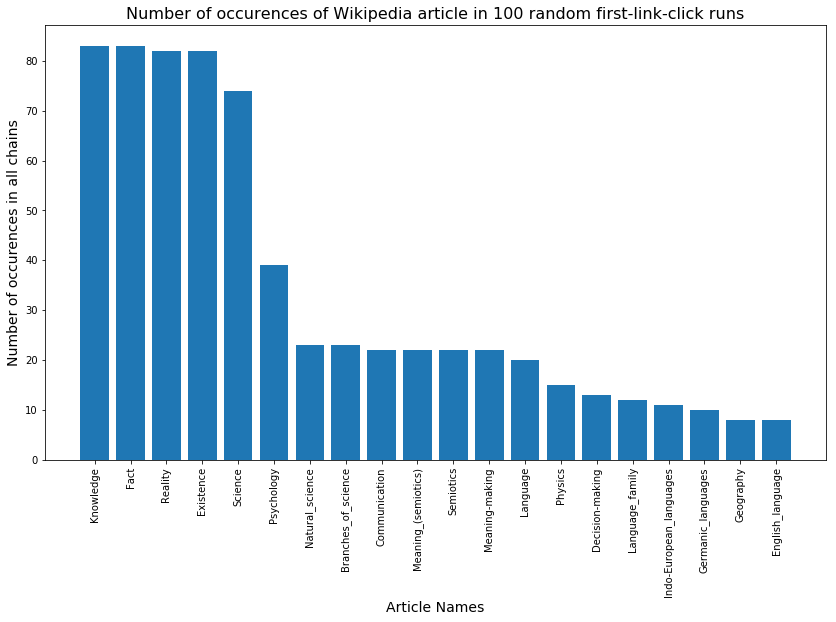

In [30]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)
rects1 = ax.bar(x, y, align = 'center')
ax.set_xticks(x)
ax.set_xticklabels(x, rotation=90)
ax.set_title("Number of occurences of Wikipedia articles in 100 random first-link-click runs", size=16)
ax.set_xlabel("Article Names", size=14)
ax.set_ylabel("Number of occurences in all chains",size=14)
plt.show()